# Homework 4 - Trade Flow
By: Alex Huang

Date: February 8, 2024

UChicago ID: 12408153

## Imports and Config

In [393]:
# Operating
import os
import shutil
import platform
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data
import statsmodels.api as sm
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import scipy as sp

# Typing
from typing import Union

import warnings
warnings.filterwarnings("ignore")

In [394]:
# Configuration
pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('ggplot')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.figure(figsize=(12, 6))

TIMESTAMP_COL_NAME = 'timestamp_utc_nanoseconds'

<Figure size 1200x600 with 0 Axes>

## Functions

In [395]:
class Compute:
    def lagged_tradeflow(timeseries: pd.DataFrame, time_column_name: str, volume_column_name: str, side_column_name: str, lag: int):
        directional_volume = timeseries[[time_column_name, volume_column_name, side_column_name]]
        directional_volume['directional_volume'] = (directional_volume[volume_column_name] * directional_volume[side_column_name])
        directional_volume = directional_volume.groupby(time_column_name)['directional_volume'].sum().to_frame()
        directional_volume = directional_volume.sort_index()
        org_cumsum = directional_volume['directional_volume'].cumsum()
        org_cumsum.name = 'cumsum'


        lagged_cumsum = org_cumsum.copy()
        lagged_cumsum.index = org_cumsum.index + (lag + 1)
        lagged_cumsum = lagged_cumsum.reindex(org_cumsum.index, method='ffill')
        lagged_cumsum.name = f'{lag}_lag_cumsum'

        new_timeseries = pd.concat([directional_volume, org_cumsum, lagged_cumsum], axis=1)
        new_timeseries[f'trailing_{lag}_tradeflow'] = org_cumsum - lagged_cumsum 
        return new_timeseries
    
    def forward_returns(timeseries: pd.DataFrame, time_column_name: str, price_column_name: str, volume_column_name, amt_lookfwd: int):
        avg_price = timeseries.groupby(time_column_name).agg({f'{price_column_name}': 'mean', f'{volume_column_name}': 'sum'}).sort_index().rename(columns={f'{price_column_name}': 'price', f'{volume_column_name}': 'total_volume'})
        # display(avg_price)
        forward_price = avg_price['price'].copy()
        forward_price.index = avg_price.index - (amt_lookfwd)
        # display(forward_price)

        forward_price = forward_price.reindex(avg_price.index, method='ffill')
        forward_price.name = f'{amt_lookfwd}_forward_price'
        # display(forward_price)
        forward_returns = forward_price / avg_price['price'] - 1
        forward_returns.name = f'{amt_lookfwd}_foward_returns'

        return pd.concat([avg_price, forward_price, forward_returns], axis=1)

    def signal(timeseries: pd.DataFrame, forecast_return_column_name: str, signal_trigger_threshold: float, forecast_duration: int):
        buy_signal_bgn:  pd.Series = pd.Series(np.where(timeseries[forecast_return_column_name] >= signal_trigger_threshold, 1, 0), index=timeseries.index)
        buy_signal_end:  pd.Series = -1 * buy_signal_bgn.shift(forecast_duration)
        buy_signal:      pd.Series = buy_signal_bgn + buy_signal_end

        sell_signal_bgn: pd.Series = pd.Series(np.where(timeseries[forecast_return_column_name] <= -signal_trigger_threshold, -1, 0), index=timeseries.index)
        sell_signal_end: pd.Series = -1 * sell_signal_bgn.shift(forecast_duration)
        sell_signal:     pd.Series = sell_signal_bgn + sell_signal_end

        net_signal:      pd.Series = buy_signal + sell_signal
        timeseries['net_signal'] = net_signal

        current_position: pd.Series = net_signal.cumsum()
        timeseries['current_position'] = current_position

        return timeseries

    def strategy_performance(timseries: pd.DataFrame, signal_column_name: str, price_column_name:str, trading_cost: float=0, base_capital: float=1, pct_per_trade: float=0.001):
        returns = timseries[price_column_name].pct_change().fillna(0)
        pnl = (1 + (timseries[signal_column_name].shift(1) * (returns) * pct_per_trade)).cumprod() * base_capital


        return pnl

    def performance_statistics(timeseries: pd.DataFrame, pnl_column_name: str):
        return_series = timeseries[pnl_column_name].pct_change().fillna(0)

        mean_return = np.mean(return_series)
        vol_return = np.std(return_series)

        # Calculate cumulative returns
        cumulative_returns = np.cumprod(1 + return_series)

        # Calculate previous peaks
        previous_peaks = np.maximum.accumulate(cumulative_returns)

        # Calculate drawdown
        drawdown = (cumulative_returns / previous_peaks) - 1

        # Calculate maximum drawdown
        max_drawdown = np.min(drawdown)


        portfolio_statistics = {}
        portfolio_statistics['Sharpe Ratio'] = [mean_return / vol_return]
        portfolio_statistics['Max Drawdown'] = [max_drawdown]

        return pd.DataFrame(portfolio_statistics)










        

In [396]:
class PlotDynamics:
    def plot_returns_ts_hist(returns_series: pd.Series, ticker_symbol: str, figsize: tuple=(12,6), bins: int=20, use_steps_post: bool=False):
        if not isinstance(returns_series, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        # if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if use_steps_post:
            ax1.plot(returns_series.index, returns_series.values, drawstyle='steps-post')
        else:
            ax1.plot(returns_series.index, returns_series.values)
        ax1.set_title(f'{ticker_symbol} Returns Time Series')
        ax1.set_xlabel(f'Time')
        ax1.set_ylabel(f'{ticker_symbol} Returns')

        ax2.hist(returns_series.values, bins=bins, color='skyblue', edgecolor='black')
        ax2.set_title(f'{ticker_symbol} Returns Histogram')
        ax2.set_xlabel(f'Returns')
        ax2.set_ylabel(f'{ticker_symbol} Returns Frequency')

        plt.tight_layout()
        plt.show()

    def plot_ts_hist(timeseries: pd.Series, ticker_symbol: str, x1label: str='Time', y1label: str='Value', x2label: str='Time', y2label: str='Frequency', title1: str='Time Series', title2: str='Histogram', figsize: tuple=(12,6), bins: int=20, use_steps_post: bool=False):
        if not isinstance(timeseries, pd.Series): raise TypeError("returns_series must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("returns_series must be type str.")
        # if not pd.api.types.is_datetime64_any_dtype(returns_series.index): raise TypeError("returns_series.index must be datetime type.")
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if use_steps_post:
            ax1.plot(timeseries.index, timeseries.values, drawstyle='steps-post')
        else:
            ax1.plot(timeseries.index, timeseries.values)
        ax1.set_title(title1)
        ax1.set_xlabel(x1label)
        ax1.set_ylabel(y1label)

        ax2.hist(timeseries.values, bins=bins, color='skyblue', edgecolor='black')
        ax2.set_title(title2)
        ax2.set_xlabel(x2label)
        ax2.set_ylabel(y2label)

        plt.tight_layout()
        plt.show()

    def plot_price_volume(ticker_df: pd.DataFrame, ticker_symbol: str, y1_label: str="Adjusted Close Price", y2_label: str="Adjusted Volume", x_label: str="Time", figsize: tuple=(12,6), price_column_name: str='adj_close', volume_column_name: str='adj_volume', use_steps_post: bool=False):
        if not isinstance(ticker_df, pd.DataFrame): raise TypeError("ticker_df must be type pd.DataFrame.")
        if not isinstance(ticker_symbol, str): raise TypeError("ticker_symbol must be type str.")
        if price_column_name not in ticker_df.columns: raise KeyError(f"'{price_column_name}' not found in dataframe.")
        if volume_column_name not in ticker_df.columns: raise KeyError(f"'{volume_column_name}' not found in dataframe.")
        # if not pd.api.types.is_datetime64_any_dtype(ticker_df.index): raise TypeError("ticker_df.index must be datetime type.")

        fig, ax1 = plt.subplots(figsize=figsize)

        # Adjusted Clost Price
        if use_steps_post:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue', drawstyle='steps-post')
        else:
            ax1.plot(ticker_df.index, ticker_df[f'{price_column_name}'], label=y1_label, color='blue')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')

        # Volume
        ax2 = ax1.twinx()
        if use_steps_post:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3, drawstyle='steps-post')
        else:
            ax2.plot(ticker_df.index, ticker_df[f'{volume_column_name}'], label=y2_label, color='green', alpha=0.3)
        ax2.set_ylabel(y2_label, color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')

        # Show the plot
        plt.title(f'{ticker_symbol} Price and Volume')
        plt.show()
    

    def plot_multiple_ts(series_to_plot: Union[list[pd.Series], pd.Series], series_labels: Union[list[str], str], ylabel: str="Values", xlabel: str="Date", title: str="Time Series", figsize: tuple=(12,6), alphas: list[float]=None):
        # Perform type checking
        if not isinstance(xlabel, str): raise TypeError("xlabel must be type str.")
        if not isinstance(ylabel, str): raise TypeError("ylabel must be type str.")
        if not isinstance(title, str): raise TypeError("title must be type str.")

        if alphas is None: alphas = [1] * len(series_to_plot)

        
        plt.figure(figsize=figsize)
        if isinstance(series_to_plot, list) and isinstance(series_labels, list):
            series: pd.Series
            for series, label, alpha in zip(series_to_plot, series_labels, alphas):
                if isinstance(series, pd.Series) and isinstance(label, str):
                    plt.plot(series.index, series.values, label=label, alpha=alpha)
                else:
                    raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")
        elif isinstance(series_to_plot, pd.Series) and isinstance(series_labels, str):
            series: pd.Series = series_to_plot
            label: str = series_labels
            alpha: float = alphas[0]
            plt.plot(series.index, series.values, label=label, alpha=alpha)
        else:
            raise TypeError("series_to_plot must be type pd.Series or type list[pd.Series].")

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_dual_axis_timeseries(x: pd.Series, y1: list[pd.Series], y2: list[pd.Series], y1_series_names: list[str]=None, y2_series_names: list[str]=None, xlabel: str='Time', y1label: str='y1', title: str='Dual Time Series Plots', y2label: str='y2', y1color: str='tab:blue', y2color: str='tab:red', figsize: tuple[int,int]=(12,6), alpha: list[int]=None, use_steps_post: list[bool]=None):
        """ 
        Plot a dual y-axis time series.

        Parameters:
            x (pd.Series): The x-axis data (time series).
            y1 (list[pd.Series]): List of y-axis data for the left y-axis.
            y2 (list[pd.Series]): List of y-axis data for the right y-axis.

        Returns:
            None
        """
        if alpha is None:
            alpha = [1] * (len(y1) + len(y2))
        if use_steps_post is None:
            use_steps_post = [False] * (len(y1) + len(y2))
        if y1_series_names is None:
            y1_series_names = [f'y1.{i}' for i in range(len(y1))]
        if y2_series_names is None:
            y2_series_names = [f'y2.{i}' for i in range(len(y2))]

        fig, ax1 = plt.subplots(figsize=figsize)

        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(y1label, color=y1color)

        alpha_index = 0
        use_steps_post_index = 0
        for y1_data, y1name in zip(y1, y1_series_names):
            if use_steps_post[use_steps_post_index] == True:
                ax1.plot(x, y1_data, color=y1color, alpha=alpha[alpha_index], label=y1name, drawstyle='steps-post')
            else:
                ax1.plot(x, y1_data, color=y1color, alpha=alpha[alpha_index], label=y1name)
            use_steps_post_index += 1
            alpha_index += 1

        ax2 = ax1.twinx()
        ax2.set_ylabel(y2label, color=y2color)
        for y2_data, y2name in zip(y2, y2_series_names):
            if use_steps_post[use_steps_post_index] == True:
                ax2.plot(x, y2_data, color=y2color, alpha=alpha[alpha_index], label=y2name, drawstyle='steps-post')
            else:
                ax2.plot(x, y2_data, color=y2color, alpha=alpha[alpha_index], label=y2name)
            use_steps_post_index += 1
            alpha_index += 1
        
        plt.legend(loc='best')
        plt.title(title)
        plt.show()

    def plot_regression_statistics(X: pd.Series, y: pd.Series, use_bias: bool=True, title: str="Regression Plot"):
        if use_bias:
            new_X = sm.add_constant(X)
        else:
            new_X = X

        model = sm.OLS(y, new_X)
        results = model.fit()
        predicted_values = results.predict(new_X)

        plt.scatter(X, y, label='Data', alpha=0.5)

        # Plot the regression line
        plt.plot(X, predicted_values, color='blue', label='Regression Line')

        # Add labels and legend
        plt.xlabel(X.name)
        plt.ylabel(y.name)
        plt.title(title)
        plt.legend()

        # Show plot
        plt.show()
        display(results.summary())

        return results



In [397]:
# data = {
#     'time': [1,3,5,6,7,9,12],
#     'vol':  [5,2,3,4,1,7,10],
#     'side': [1,1,-1,1,1,-1,-1]
# }
data = {
    'time': [0] + [i for i in range(3,21,2)],
    'vol': [1] * 10,
    'side': list(range(1,11))
}
# data = {
#     'time': list(range(10)),
#     'vol': list(range(1,11)),
#     'side': [1] * 10
# }
data = pd.DataFrame(data)
data
Compute.lagged_tradeflow(data, 'time', 'vol', 'side', 2)

,directional_volume,cumsum,2_lag_cumsum,trailing_2_tradeflow
time,,,,
0,1,1,NaN,NaN
3,2,3,1.0000,2.0000
5,3,6,1.0000,5.0000
7,4,10,3.0000,7.0000
9,5,15,6.0000,9.0000
11,6,21,10.0000,11.0000
13,7,28,15.0000,13.0000
15,8,36,21.0000,15.0000
17,9,45,28.0000,17.0000


In [398]:
import pandas as pd

# Example left and right series
left_series = pd.Series([1, 2, 3], index=[0, 2, 6])
right_series = pd.Series([10, 20, 30], index=[1, 3, 5])
display(left_series)
display(right_series)
# Reindex the left series using the index of the right series
merged_series = left_series.reindex(right_series.index, method='ffill')

# Resulting merged series
print(merged_series)


0    1
2    2
6    3
dtype: int64

1    10
3    20
5    30
dtype: int64

1    1
3    2
5    2
dtype: int64


In [399]:
data = {
    'time': list(range(1,21,2)),
    'price': list(range(1,11))
}

data = pd.DataFrame(data)


# Table of Contents

> - [**I. Introduction: Overview and Objective**](#i-introduction-overview-and-objective)
   >> - [1. Overview](#1-overview)
   >> - [2. Objective](#2-objective)
> - [**II. Gathering Data: Fetching, Filtering, Cleaning, and Configuration**](#ii-gathering-data-fetching-filtering-cleaning-and-configuration)
   >> - [1. Fetching Data](#1-fetching-data)
   >> - [2. Filtering/Cleaning Data](#2-filteringcleaning-data)
   >> - [3. Validation](#3-validation)
> - [**III. Exploration: Dynamics**](#iii-exploration-dynamics)
   >> - [1. Equally Weighted Portfolio Dyanmics](#1-gds-dynamics-and-ring-dynamics)
      >>> - [A. Equally Weighted: Price Dynamics](#a-price-dynamics)
      >>> - [B. Equally Weighted: Returns Dynamics](#b-returns-dynamics)
      >>> - [C. Equally Weighted: Spread Dynamics](#c-spread-dynamics)
   >> - [2. Market Capitalization Weighted Portfolio Dynamics](#1-gds-dynamics-and-ring-dynamics)
      >>> - [A. Market Cap Weighted: Price Dynamics](#a-price-dynamics)
      >>> - [B. Market Cap Weighted: Returns Dynamics](#b-returns-dynamics)
      >>> - [C. Market Cap Weighted: Spread Dynamics](#c-spread-dynamics)
   >> - [3. Ranking Weighted Portfolio Dynamics](#1-gds-dynamics-and-ring-dynamics)
      >>> - [A. Ranking Weighted: Price Dynamics](#a-price-dynamics)
      >>> - [B. Ranking Weighted: Returns Dynamics](#b-returns-dynamics)
      >>> - [C. Ranking Weighted: Spread Dynamics](#c-spread-dynamics)
> - [**IV. Strategy and Implementation:**](#iv-strategy-and-implementation)
   >> - [1. Strategy Overview](#1-strategy-overview)
   >> - [2. Signal Processing: Entry, Exit, Stop Limit](#2-signal-processing-entry-exit-stop-limit)
   >> - [3. Position Sizing](#3-position-sizing)
   >> - [4. Parameter Tuning](#4-parameter-tuning)
   >> - [5. Trade Performance](#5-trade-performance)
> - [**V. Analysis of Trading Strategies:**](#v-analysis-of-trading-strategy)
   >> - [1. Overview of Analysis](#1-overview-of-analysis)
   >> - [2. Decomposition using Fama-French 3 Factor Model](#2-decomposition-using-fama-french-3-factor-model)
   >> - [3. Fama-French Decomposition Conclusion](#3-fama-french-decomposition-conclusion)
   >> - [4. Trading Strategy Performance in High/Low Volatility](#4-trading-strategy-performance-in-highlow-volatility)
> - [**VI. Research Conclusion**](#vi-research-conclusion)
   >> - [1. Conclusion Report](#1-conclusion-report)

## I. Introduction: Overview and Objective

### 1. Overview
***

In this assignment we will evaluate trade flow data to identify profit opportunities in three cryptotoken markets. Utilizing preprocessed level 3 exchange messages from the Coinbase WebSocket API, we will split the data into training and test sets and then compute τ-interval trade flow just prior to each trade data point. By regressing these flow values against T-second forward returns in the training set, we will derive a coefficient β for regression. Subsequently, they predict returns for each data point in the test set and assess trading opportunities considering trading cost assumptions, examining metrics like Sharpe ratios, drawdowns, and tails.

### 2. Objective 
***

The objective is to develop a systematic approach to leverage trade flow data for profit prediction in cryptotoken markets. We will implement code to compute trade flow prior to each trade, predict returns based on regression analysis, and evaluate trading opportunities in the test set. Through analyzing metrics such as Sharpe ratios and drawdowns, students will assess the effectiveness of return predictions. Furthermore, we will examine the reliability of regression coefficient β, determine appropriate thresholds for trading based on return predictions, and consider the implications of using longer training and test periods for more robust analysis.

## II. Gathering Data: Fetching, Filtering, Cleaning, and Configuration

### 1. Fetching and Filtering
***

Our data source is from the CoinBase API. Mannually downloaded and read into the system.

In [400]:
book_btc_usd_df = pd.read_csv(r'./data/book_narrow_BTC-USD_2023.delim', sep='\t')
book_eth_btc_df = pd.read_csv(r'./data/book_narrow_ETH-BTC_2023.delim', sep='\t')
book_eth_usd_df = pd.read_csv(r'./data/book_narrow_ETH-USD_2023.delim', sep='\t')
trades_btc_usd_df = pd.read_csv(r'./data/trades_narrow_BTC-USD_2023.delim', sep='\t')
trades_eth_btc_df = pd.read_csv(r'./data/trades_narrow_ETH-BTC_2023.delim', sep='\t')
trades_eth_usd_df = pd.read_csv(r'./data/trades_narrow_ETH-USD_2023.delim', sep='\t')

### 2. Cleaning 
***
We clean the data by sorting by the clock time of the trading data and the book data.

In [401]:
book_btc_usd_df = book_btc_usd_df.sort_values(TIMESTAMP_COL_NAME)
book_eth_btc_df = book_eth_btc_df.sort_values(TIMESTAMP_COL_NAME)
book_eth_usd_df = book_eth_usd_df.sort_values(TIMESTAMP_COL_NAME)
trades_btc_usd_df = trades_btc_usd_df.sort_values(TIMESTAMP_COL_NAME)
trades_eth_btc_df = trades_eth_btc_df.sort_values(TIMESTAMP_COL_NAME)
trades_eth_usd_df = trades_eth_usd_df.sort_values(TIMESTAMP_COL_NAME)

### 3. Configuration
***
We configure our data by splitting the data of each pair (BTC-USD, ETH-BTC, ETH-USD) into a training set and a testing set. This is set via the `train_split_portion` variable.


**Tables:**
***
**Book Tables:**

> `train_book_btc_usd_df`: Training portion of the book data for BTC-USD

> `test_book_btc_usd_df`: Testing portion of the book data for BTC-USD

> `train_book_eth_btc_df`: Training portion of the book data for ETH-BTC

> `test_book_eth_btc_df`: Testing portion of the book data for ETH-BTC

> `train_book_eth_btc_df`: Training portion of the book data for ETH-USD

> `test_book_eth_btc_df`: Testing portion of the book data for ETH-USD

**Trade Tables:**

> `train_trades_btc_usd_df`: Training portion of the trade data for BTC-USD

> `test_trades_btc_usd_df`: Testing portion of the btradedata for BTC-USD

> `train_trades_eth_btc_df`: Training portion of the trade data for ETH-BTC

> `test_trades_eth_btc_df`: Testing portion of the btradedata for ETH-BTC

> `train_trades_eth_btc_df`: Training portion of the trade data for ETH-USD

> `test_trades_eth_btc_df`: Testing portion of the btradedata for ETH-USD

In [402]:
train_split_portion = 0.4

# Splitting book_btc_usd_df
train_book_btc_usd_df = book_btc_usd_df.iloc[:int(book_btc_usd_df.shape[0] * train_split_portion)]
test_book_btc_usd_df = book_btc_usd_df.iloc[int(book_btc_usd_df.shape[0] * train_split_portion):]

# Splitting book_eth_btc_df
train_book_eth_btc_df = book_eth_btc_df.iloc[:int(book_eth_btc_df.shape[0] * train_split_portion)] 
test_book_eth_btc_df = book_eth_btc_df.iloc[int(book_eth_btc_df.shape[0] * train_split_portion):]

# Splitting book_eth_usd_df
train_book_eth_usd_df = book_eth_usd_df.iloc[:int(book_eth_usd_df.shape[0] * train_split_portion)] 
test_book_eth_usd_df = book_eth_usd_df.iloc[int(book_eth_usd_df.shape[0] * train_split_portion):]

# Splitting trades_btc_usd_df
train_trades_btc_usd_df = trades_btc_usd_df.iloc[:int(trades_btc_usd_df.shape[0] * train_split_portion)] 
test_trades_btc_usd_df = trades_btc_usd_df.iloc[int(trades_btc_usd_df.shape[0] * train_split_portion):]

# Splitting trades_eth_btc_df
train_trades_eth_btc_df = trades_eth_btc_df.iloc[:int(trades_eth_btc_df.shape[0] * train_split_portion)] 
test_trades_eth_btc_df = trades_eth_btc_df.iloc[int(trades_eth_btc_df.shape[0] * train_split_portion):]

# Splitting trades_eth_usd_df
train_trades_eth_usd_df = trades_eth_usd_df.iloc[:int(trades_eth_usd_df.shape[0] * train_split_portion)] 
test_trades_eth_usd_df = trades_eth_usd_df.iloc[int(trades_eth_usd_df.shape[0] * train_split_portion):]


## III. Dynamics Of The Underlying

### 1. Price Dynamics
***

**Parameters:**

`LAGGED_TRADEFLOW_TIME` = 5 seconds (This is the main parameter to compute the T second window trade flow.)

`FORWARD_RETURN_TIME_INTERVAL` = 5 seconds (This is the main parameter to compute the Tau second window for forward returns.)

In [407]:
LAGGED_TRADEFLOW_TIME = 5e9
FORWARD_RETURN_TIME_INTERVAL = 5e9
fr_trades_btc_usd_df = Compute.forward_returns(trades_btc_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
fr_trades_eth_btc_df = Compute.forward_returns(trades_eth_btc_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
fr_trades_eth_usd_df = Compute.forward_returns(trades_eth_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)


#### BTC-USD Pair Dynamics

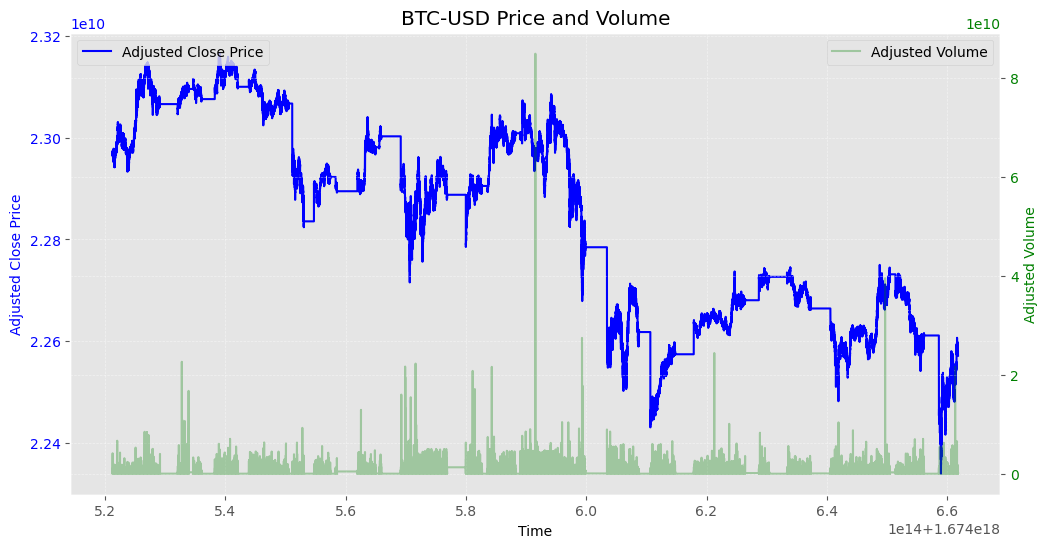

In [473]:
PlotDynamics.plot_price_volume(fr_trades_btc_usd_df, 'BTC-USD', price_column_name='price', volume_column_name='total_volume', use_steps_post=True)

#### ETH-BTC Pair Dynamics

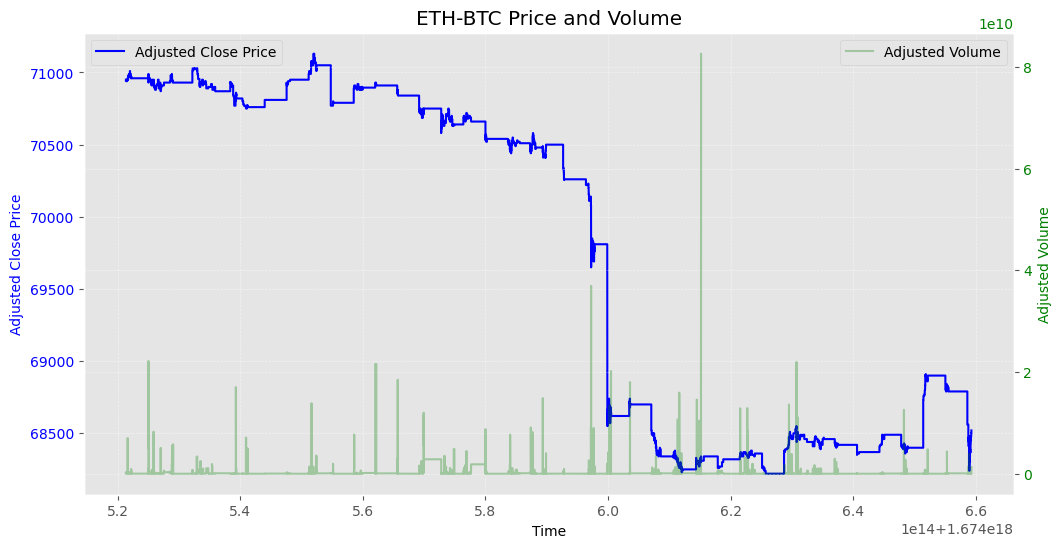

In [410]:
PlotDynamics.plot_price_volume(fr_trades_eth_btc_df, 'ETH-BTC', price_column_name='price', volume_column_name='total_volume', use_steps_post=True)

#### ETH-USD Pair Dynamics

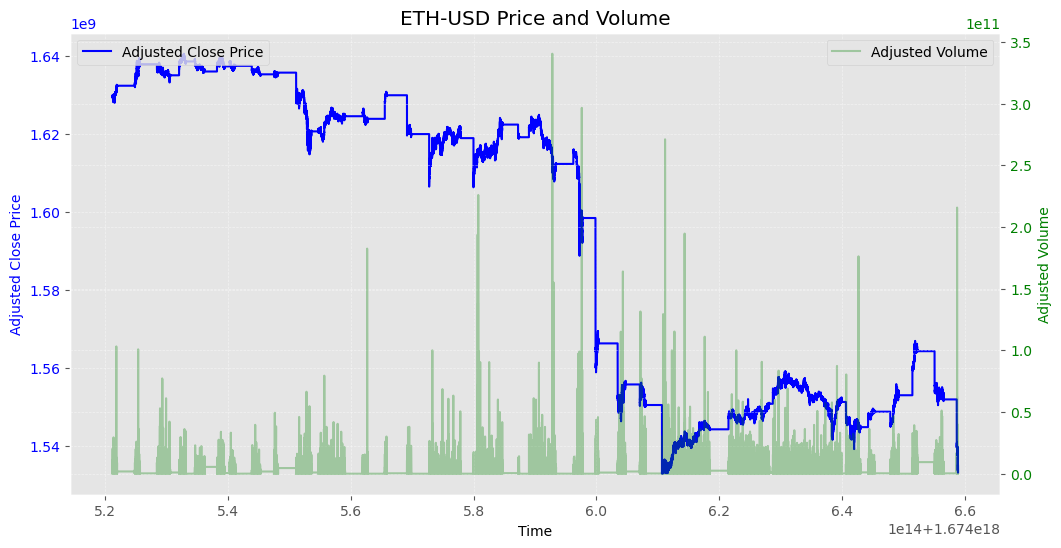

In [411]:
PlotDynamics.plot_price_volume(fr_trades_eth_usd_df, 'ETH-USD', price_column_name='price', volume_column_name='total_volume', use_steps_post=True)

### Return Dynamics

#### BTC-USD Forward Return Dynamics

In [412]:
fr_trades_btc_usd_df
fr_trades_eth_btc_df
fr_trades_eth_usd_df

,price,total_volume,5000000000.0_forward_price,5000000000.0_foward_returns
timestamp_utc_nanoseconds,,,,
1674521271071902000,"1,629,670,000.0000",11815210,"1,629,855,000.0000",0.0001
1674521271398509000,"1,629,780,000.0000",1821747820,"1,629,850,000.0000",0.0000
1674521271578052000,"1,629,770,000.0000",92150000,"1,629,850,000.0000",0.0000
1674521271660995000,"1,629,795,000.0000",613560000,"1,629,840,000.0000",0.0000
1674521271885174000,"1,629,895,000.0000",480000000,"1,629,835,000.0000",-0.0000
...,...,...,...,...
1674658830318655000,"1,533,320,000.0000",4554000080,"1,533,300,000.0000",-0.0000
1674658830318708000,"1,533,335,000.0000",7617832610,"1,533,300,000.0000",-0.0000
1674658830319185000,"1,533,310,000.0000",2095786600,"1,533,300,000.0000",-0.0000


#### BTC-USD Fowarward Return Dynamics

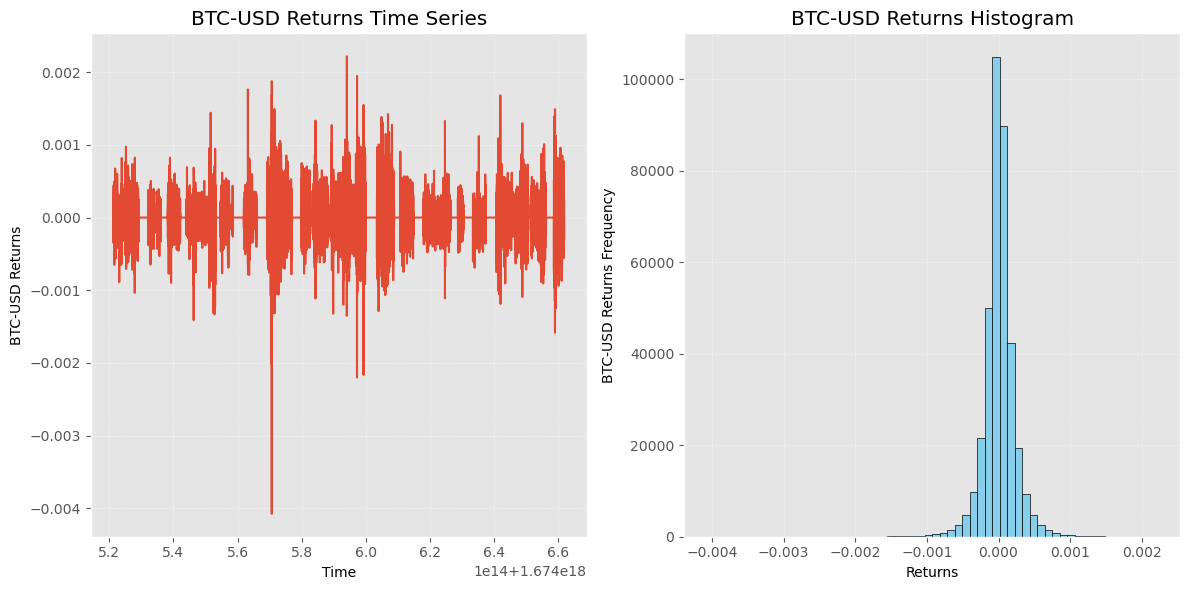

In [413]:
PlotDynamics.plot_returns_ts_hist(fr_trades_btc_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'], 'BTC-USD', bins=60, use_steps_post=True)

#### ETH-BTC Fowarward Return Dynamics

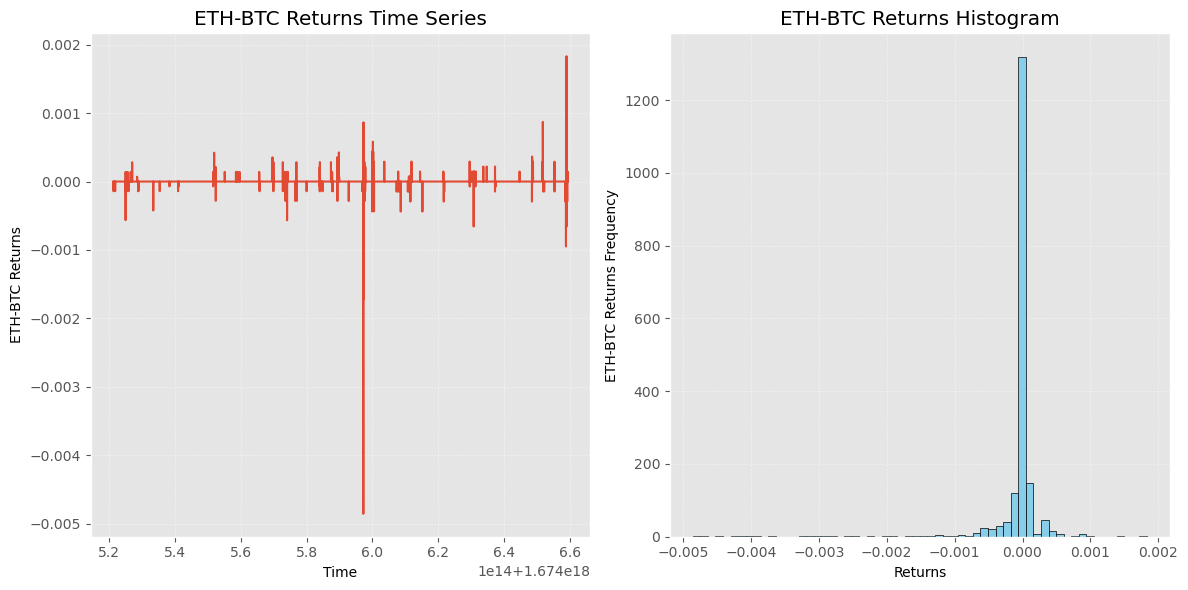

In [414]:
PlotDynamics.plot_returns_ts_hist(fr_trades_eth_btc_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'], 'ETH-BTC', bins=60, use_steps_post=True)

#### ETH-USD Fowarward Return Dynamics

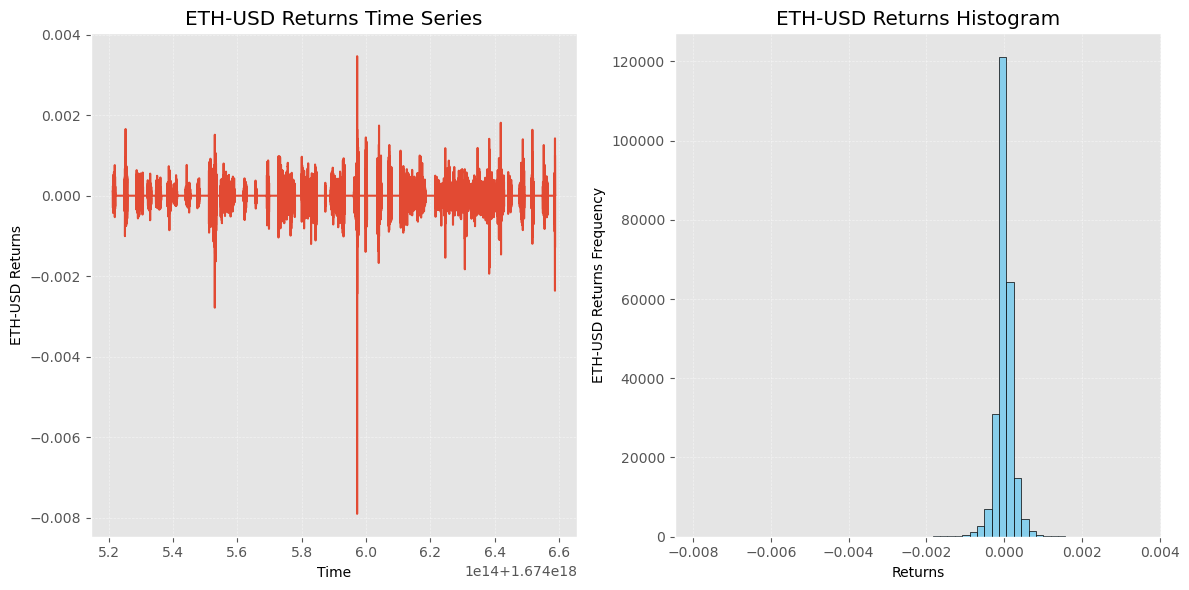

In [415]:
PlotDynamics.plot_returns_ts_hist(fr_trades_eth_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'], 'ETH-USD', bins=60, use_steps_post=True)

### Correlation

array([[<Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>,
        <Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>,
        <Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>],
       [<Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>,
        <Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>,
        <Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>],
       [<Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>,
        <Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>,
        <Axes: xlabel='5000000000.0_foward_returns', ylabel='5000000000.0_foward_returns'>]],
      dtype=object)

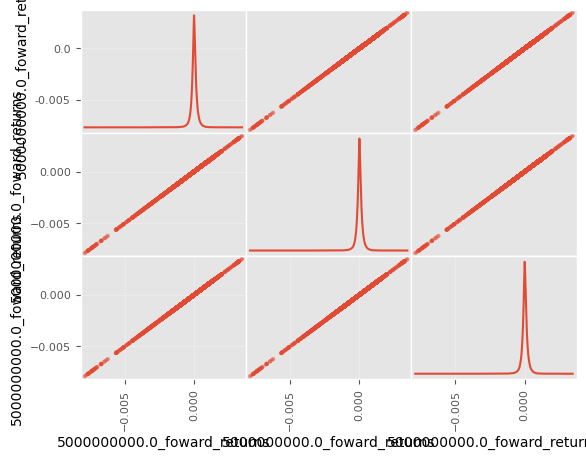

In [416]:
scatter_matrix(
    pd.concat([
        fr_trades_btc_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
        fr_trades_eth_btc_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
        fr_trades_eth_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns']
    ], axis=1)
    , diagonal='kde'
    ) 

### Trade Flow Momentum

In [417]:
# LAGGED_TRADEFLOW_TIME = 5e9
frtf_train_trades_btc_usd_df: pd.DataFrame = Compute.forward_returns(train_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_train_trades_eth_btc_df: pd.DataFrame = Compute.forward_returns(train_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_train_trades_eth_usd_df: pd.DataFrame = Compute.forward_returns(train_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)

frtf_train_trades_btc_usd_df = frtf_train_trades_btc_usd_df.merge(
    Compute.lagged_tradeflow(train_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_train_trades_eth_btc_df = frtf_train_trades_eth_btc_df.merge(
    Compute.lagged_tradeflow(train_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_train_trades_eth_usd_df = frtf_train_trades_eth_usd_df.merge(
    Compute.lagged_tradeflow(train_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()

In [418]:
# LAGGED_TRADEFLOW_TIME = 5e9
frtf_test_trades_btc_usd_df: pd.DataFrame = Compute.forward_returns(test_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_test_trades_eth_btc_df: pd.DataFrame = Compute.forward_returns(test_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
frtf_test_trades_eth_usd_df: pd.DataFrame = Compute.forward_returns(test_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'PriceMillionths', 'SizeBillionths', FORWARD_RETURN_TIME_INTERVAL)
# display(frtf_test_trades_btc_usd_df.shape)

frtf_test_trades_btc_usd_df = frtf_test_trades_btc_usd_df.merge(
    Compute.lagged_tradeflow(test_trades_btc_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_test_trades_eth_btc_df = frtf_test_trades_eth_btc_df.merge(
    Compute.lagged_tradeflow(test_trades_eth_btc_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()
frtf_test_trades_eth_usd_df = frtf_test_trades_eth_usd_df.merge(
    Compute.lagged_tradeflow(test_trades_eth_usd_df, TIMESTAMP_COL_NAME, 'SizeBillionths', 'Side', LAGGED_TRADEFLOW_TIME),
    left_index=True, right_index=True, how='left'
).dropna()

#### BTC-USD Regression: Trade Flow on Future Returns

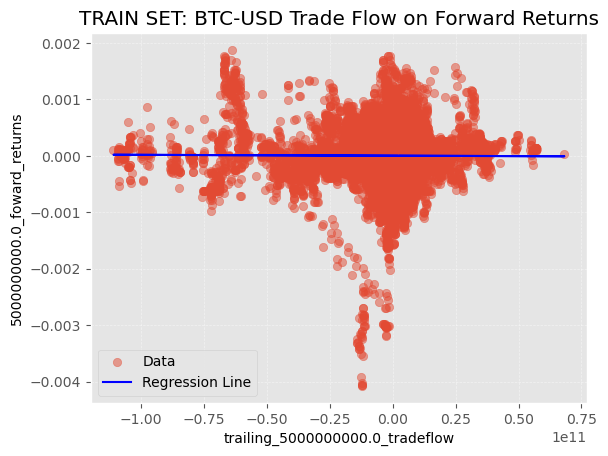

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared (uncentered):                   0.000
Model:                                     OLS   Adj. R-squared (uncentered):              0.000
Method:                          Least Squares   F-statistic:                              2.883
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):                      0.0895
Time:                                 18:35:39   Log-Likelihood:                      1.0116e+06
No. Observations:                       145003   AIC:                                 -2.023e+06
Df Residuals:                           145002   BIC:                                 -2.023e+06
Df Model:                                    1                                                  
Covariance Type:                     nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
trailing_5000000000.0_tradeflow -1.493e-16    8.8e-17     -1.698      0.090   -3.22e-16     2.3e-17
==============================================================================
Omnibus:                    59551.259   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3194705.185
Skew:                          -1.203   Prob(JB):                         0.00
Kurtosis:                      25.869   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [419]:
train_fixed_beta_btc_usd_model = PlotDynamics.plot_regression_statistics(
    frtf_train_trades_btc_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_train_trades_btc_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=False,
    title='TRAIN SET: BTC-USD Trade Flow on Forward Returns'
    )

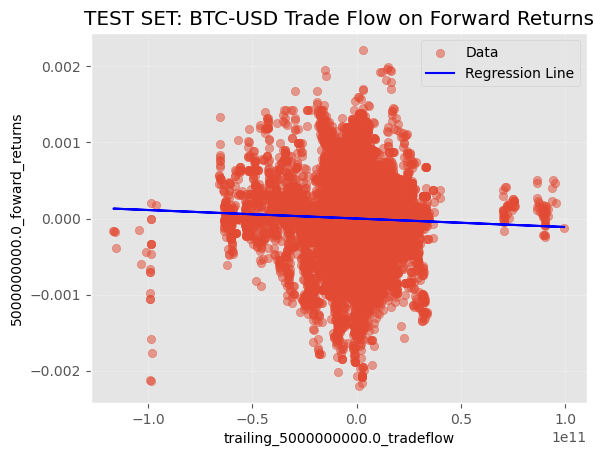

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared (uncentered):                   0.001
Model:                                     OLS   Adj. R-squared (uncentered):              0.001
Method:                          Least Squares   F-statistic:                              161.9
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):                    4.39e-37
Time:                                 18:35:40   Log-Likelihood:                      1.5699e+06
No. Observations:                       224413   AIC:                                 -3.140e+06
Df Residuals:                           224412   BIC:                                 -3.140e+06
Df Model:                                    1                                                  
Covariance Type:                     nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
trailing_5000000000.0_tradeflow -1.118e-15   8.78e-17    -12.726      0.000   -1.29e-15   -9.46e-16
==============================================================================
Omnibus:                    32369.625   Durbin-Watson:                   0.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           443999.648
Skew:                          -0.199   Prob(JB):                         0.00
Kurtosis:                       9.879   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [420]:
test_fixed_beta_btc_usd_model = PlotDynamics.plot_regression_statistics(
    frtf_test_trades_btc_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_test_trades_btc_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=False,
    title='TEST SET: BTC-USD Trade Flow on Forward Returns'
    )

#### ETH-BTC Regression: Trade Flow on Future Returns

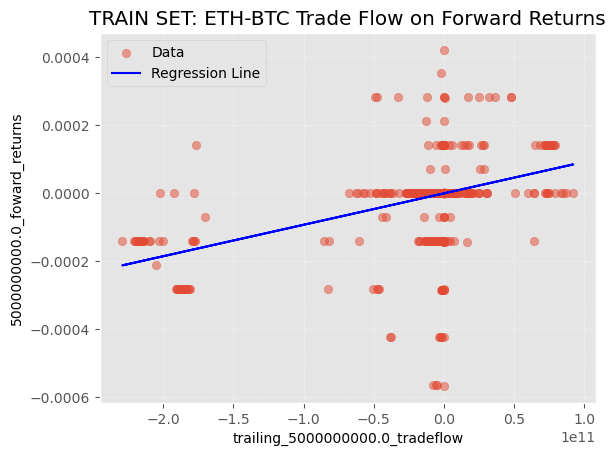

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared (uncentered):                   0.193
Model:                                     OLS   Adj. R-squared (uncentered):              0.192
Method:                          Least Squares   F-statistic:                              176.7
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):                    2.57e-36
Time:                                 18:35:40   Log-Likelihood:                          5799.0
No. Observations:                          741   AIC:                                 -1.160e+04
Df Residuals:                              740   BIC:                                 -1.159e+04
Df Model:                                    1                                                  
Covariance Type:                     nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
trailing_5000000000.0_tradeflow  9.236e-16   6.95e-17     13.294      0.000    7.87e-16    1.06e-15
==============================================================================
Omnibus:                      279.643   Durbin-Watson:                   0.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3200.037
Skew:                          -1.361   Prob(JB):                         0.00
Kurtosis:                      12.810   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [421]:
train_fixed_beta_eth_btc_model = PlotDynamics.plot_regression_statistics(
    frtf_train_trades_eth_btc_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_train_trades_eth_btc_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=False,
    title='TRAIN SET: ETH-BTC Trade Flow on Forward Returns'
    )

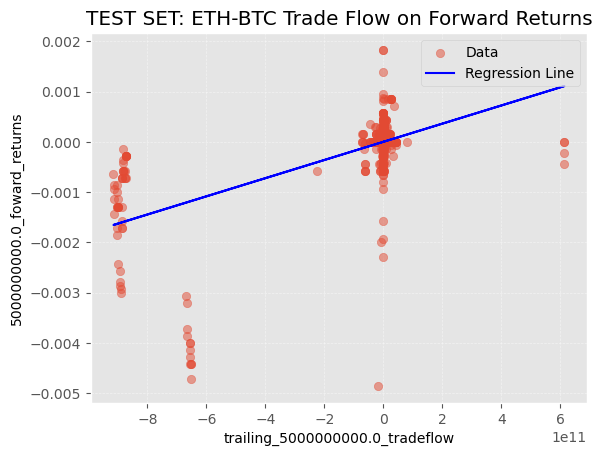

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared (uncentered):                   0.392
Model:                                     OLS   Adj. R-squared (uncentered):              0.391
Method:                          Least Squares   F-statistic:                              706.8
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):                   1.24e-120
Time:                                 18:35:40   Log-Likelihood:                          6914.5
No. Observations:                         1099   AIC:                                 -1.383e+04
Df Residuals:                             1098   BIC:                                 -1.382e+04
Df Model:                                    1                                                  
Covariance Type:                     nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
trailing_5000000000.0_tradeflow  1.809e-15    6.8e-17     26.586      0.000    1.68e-15    1.94e-15
==============================================================================
Omnibus:                     1007.258   Durbin-Watson:                   0.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52483.951
Skew:                          -4.050   Prob(JB):                         0.00
Kurtosis:                      35.872   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [422]:
test_fixed_beta_eth_btc_model = PlotDynamics.plot_regression_statistics(
    frtf_test_trades_eth_btc_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_test_trades_eth_btc_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=False,
    title='TEST SET: ETH-BTC Trade Flow on Forward Returns'
    )

#### ETH-USD Regression: Trade Flow on Future Returns

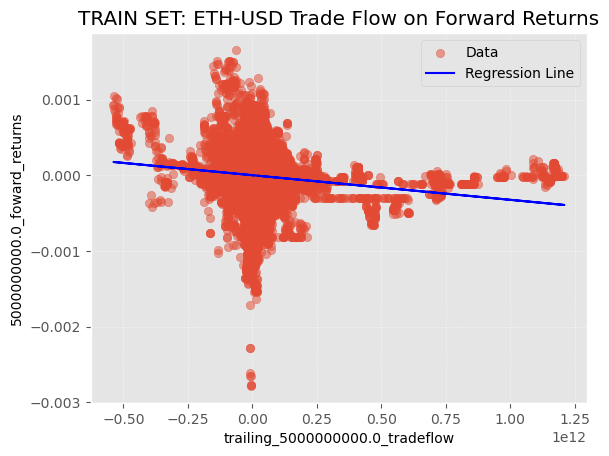

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared:                       0.010
Model:                                     OLS   Adj. R-squared:                  0.010
Method:                          Least Squares   F-statistic:                       nan
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):                nan
Time:                                 18:35:41   Log-Likelihood:             7.0243e+05
No. Observations:                        99009   AIC:                        -1.405e+06
Df Residuals:                            99008   BIC:                        -1.405e+06
Df Model:                                    0                                         
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
trailing_5000000000.0_tradeflow -3.249e-16   9.88e-18    -32.888      0.000   -3.44e-16   -3.06e-16
==============================================================================
Omnibus:                    19207.266   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           304124.638
Skew:                          -0.490   Prob(JB):                         0.00
Kurtosis:                      11.530   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [423]:
train_fixed_beta_eth_usd_model = PlotDynamics.plot_regression_statistics(
    frtf_train_trades_eth_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_train_trades_eth_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=False,
    title='TRAIN SET: ETH-USD Trade Flow on Forward Returns'
    )



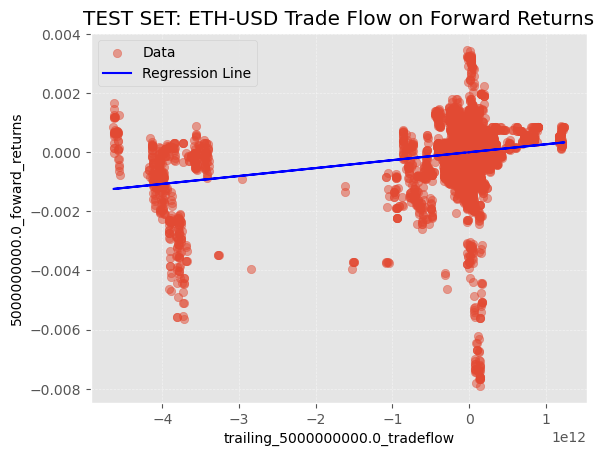

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     5000000000.0_foward_returns   R-squared:                       0.041
Model:                                     OLS   Adj. R-squared:                  0.041
Method:                          Least Squares   F-statistic:                       nan
Date:                         Thu, 08 Feb 2024   Prob (F-statistic):                nan
Time:                                 18:35:42   Log-Likelihood:             1.0163e+06
No. Observations:                       151220   AIC:                        -2.033e+06
Df Residuals:                           151219   BIC:                        -2.033e+06
Df Model:                                    0                                         
Covariance Type:                     nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
trailing_5000000000.0_tradeflow  2.681e-16   3.31e-18     80.884      0.000    2.62e-16    2.75e-16
==============================================================================
Omnibus:                   178075.831   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        114628773.194
Skew:                          -5.605   Prob(JB):                         0.00
Kurtosis:                     137.413   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [424]:
test_fixed_beta_eth_usd_model = PlotDynamics.plot_regression_statistics(
    frtf_test_trades_eth_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow'],
    frtf_test_trades_eth_usd_df[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns'],
    use_bias=False,
    title='TEST SET: ETH-USD Trade Flow on Forward Returns'
    )



## IV. Trading Strategy

In [425]:
j = 0.00001

#### Creating Testing DataFrame

### Fixed Beta

#### Fixed Beta: BTC-USD PnL

In [426]:
frtf_train_trades_btc_usd_df[f'forecasted_returns'] = train_fixed_beta_btc_usd_model.predict(frtf_train_trades_btc_usd_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']])
j = np.percentile(abs(frtf_train_trades_btc_usd_df['forecasted_returns']), 5)

frtf_test_trades_btc_usd_df[f'forecasted_returns'] = train_fixed_beta_btc_usd_model.predict(frtf_test_trades_btc_usd_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']])
frtf_test_trades_btc_usd_df = Compute.signal(frtf_test_trades_btc_usd_df, f'forecasted_returns', j, 10000)
frtf_test_trades_btc_usd_df['PnL'] = Compute.strategy_performance(frtf_test_trades_btc_usd_df, 'current_position', 'price')

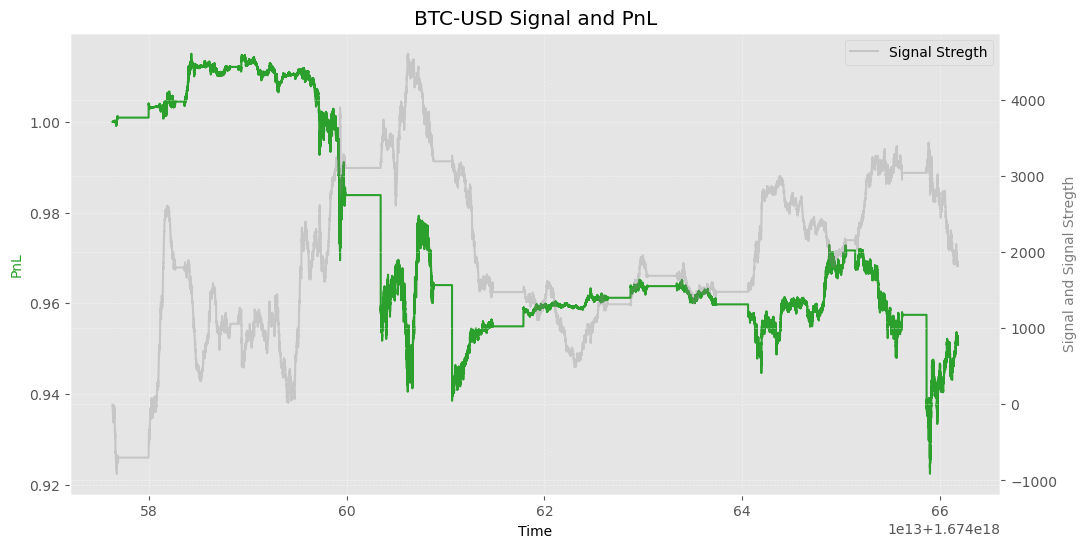

In [427]:
PlotDynamics.plot_dual_axis_timeseries(
    frtf_test_trades_btc_usd_df.index, 
    [frtf_test_trades_btc_usd_df['PnL']],
    [frtf_test_trades_btc_usd_df['current_position']], 
    y1_series_names=['PnL'],
    y2_series_names=['Signal Stregth'],
    y1label='PnL',
    y2label='Signal and Signal Stregth',
    y1color='tab:green',
    y2color='tab:grey',
    title='BTC-USD Signal and PnL',
    use_steps_post=[True, True],
    alpha=[1,0.3]
)

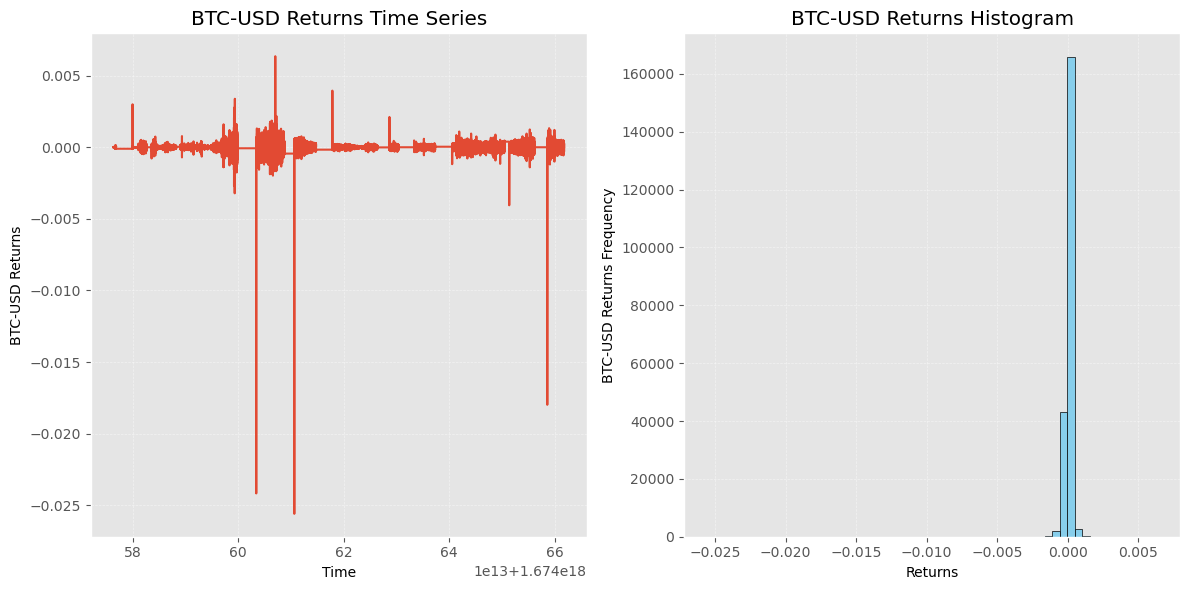

In [428]:
PlotDynamics.plot_returns_ts_hist(
    frtf_test_trades_btc_usd_df['PnL'].pct_change(),
    'BTC-USD',
    bins=60,
    use_steps_post=True
)

In [429]:
Compute.performance_statistics(
    frtf_test_trades_btc_usd_df, 'PnL'
)

,Sharpe Ratio,Max Drawdown
0,-0.0010,-0.0913


#### Fixed Beta: ETH-BTC PnL

In [430]:
frtf_train_trades_eth_btc_df[f'forecasted_returns'] = train_fixed_beta_eth_btc_model.predict(frtf_train_trades_eth_btc_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']])
j = np.percentile(abs(frtf_train_trades_eth_btc_df['forecasted_returns']), 5)

frtf_test_trades_eth_btc_df[f'forecasted_returns'] = train_fixed_beta_eth_btc_model.predict(frtf_test_trades_eth_btc_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']])
frtf_test_trades_eth_btc_df = Compute.signal(frtf_test_trades_eth_btc_df, f'forecasted_returns', j, 10)
# frtf_test_trades_eth_btc_df
frtf_test_trades_eth_btc_df['PnL'] = Compute.strategy_performance(frtf_test_trades_eth_btc_df, 'current_position', 'price', pct_per_trade=0.01)

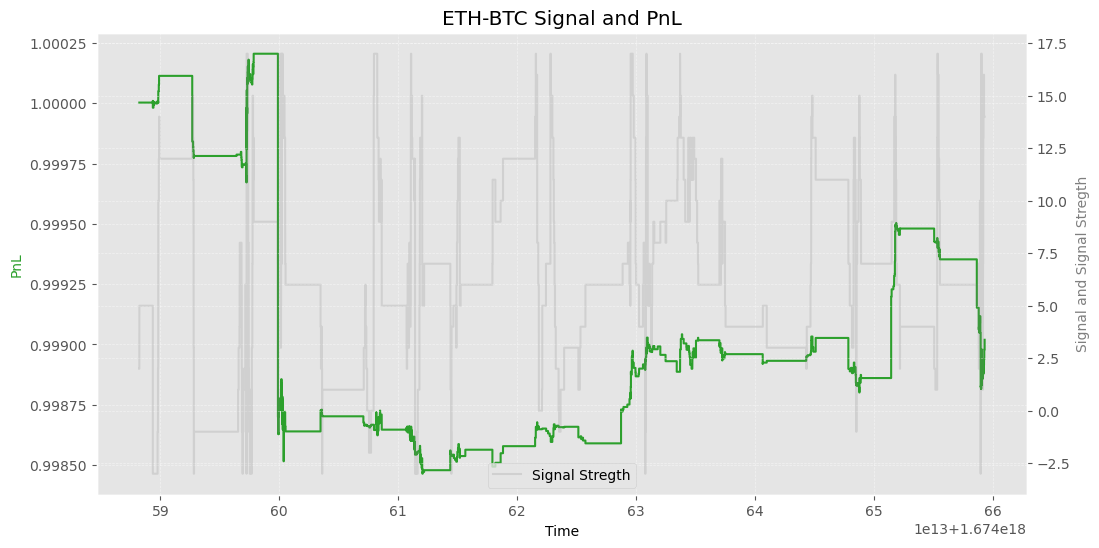

In [431]:
PlotDynamics.plot_dual_axis_timeseries(
    frtf_test_trades_eth_btc_df.index, 
    [frtf_test_trades_eth_btc_df['PnL']],
    [frtf_test_trades_eth_btc_df['current_position']], 
    y1_series_names=['PnL'],
    y2_series_names=['Signal Stregth'],
    y1label='PnL',
    y2label='Signal and Signal Stregth',
    y1color='tab:green',
    y2color='tab:grey',
    title='ETH-BTC Signal and PnL',
    use_steps_post=[True, True],
    alpha=[1.0,0.2],
    
)

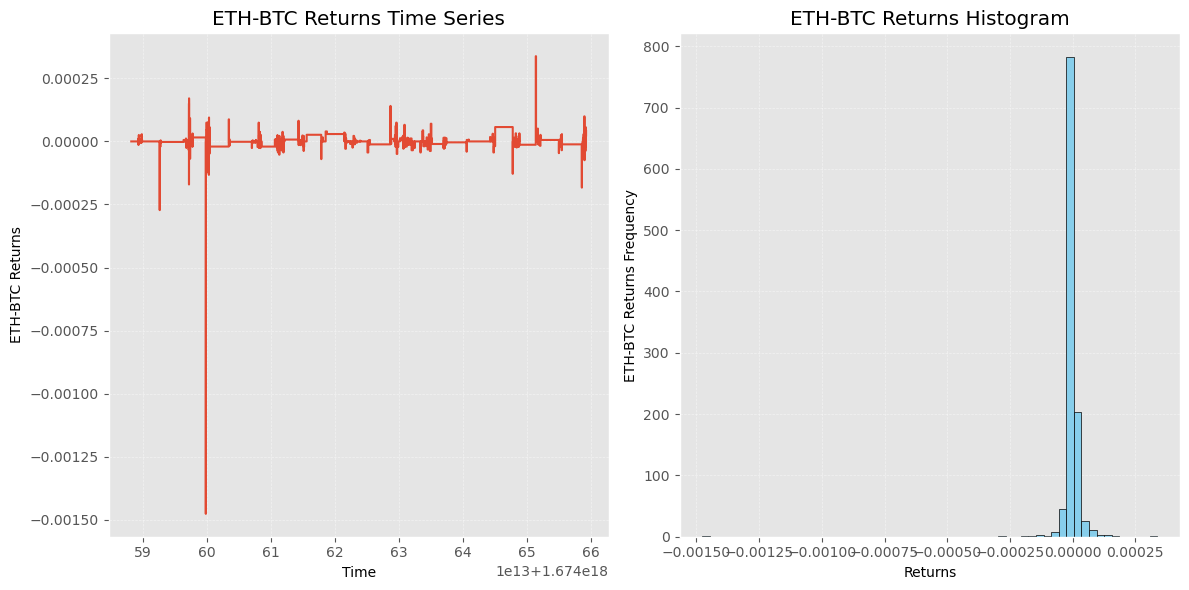

In [432]:
PlotDynamics.plot_returns_ts_hist(
    frtf_test_trades_eth_btc_df['PnL'].pct_change(),
    'ETH-BTC',
    bins=60,
    use_steps_post=True
)

In [433]:
Compute.performance_statistics(
    frtf_test_trades_eth_btc_df, 'PnL'
)

,Sharpe Ratio,Max Drawdown
0,-0.0174,-0.0017


#### Fixed Beta: ETH-USD PnL

In [434]:
frtf_train_trades_eth_usd_df[f'forecasted_returns'] = train_fixed_beta_eth_usd_model.predict(frtf_train_trades_eth_usd_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']])
j = np.percentile(abs(frtf_train_trades_eth_usd_df['forecasted_returns']), 5)

frtf_test_trades_eth_usd_df[f'forecasted_returns'] = train_fixed_beta_eth_usd_model.predict(frtf_test_trades_eth_usd_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']])
frtf_test_trades_eth_usd_df = Compute.signal(frtf_test_trades_eth_usd_df, f'forecasted_returns', j, 10000)
frtf_test_trades_eth_usd_df['PnL'] = Compute.strategy_performance(frtf_test_trades_eth_usd_df, 'current_position', 'price')

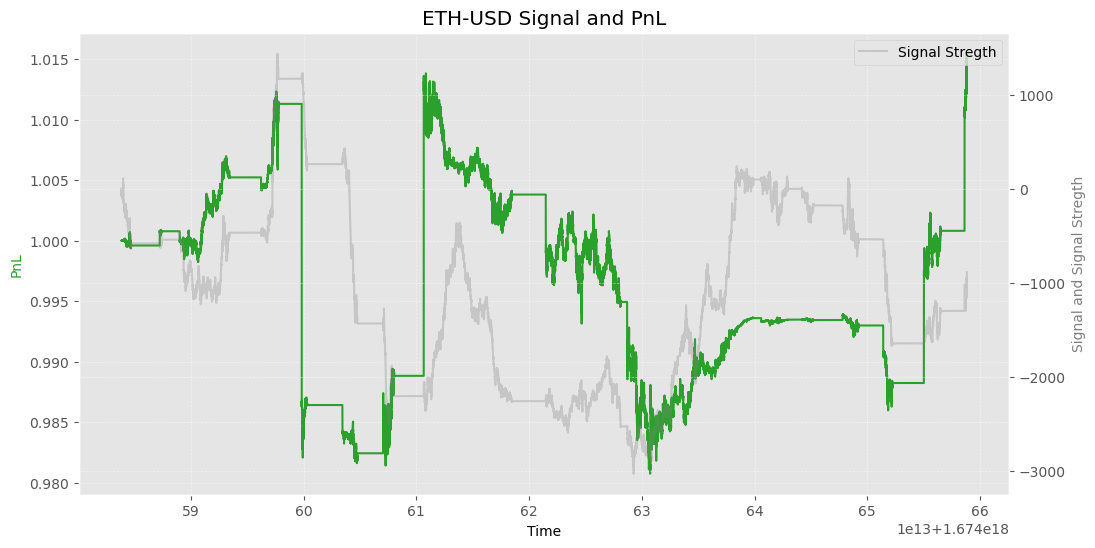

In [435]:
PlotDynamics.plot_dual_axis_timeseries(
    frtf_test_trades_eth_usd_df.index, 
    [frtf_test_trades_eth_usd_df['PnL']],
    [frtf_test_trades_eth_usd_df['current_position']], 
    y1_series_names=['PnL'],
    y2_series_names=['Signal Stregth'],
    y1label='PnL',
    y2label='Signal and Signal Stregth',
    y1color='tab:green',
    y2color='tab:grey',
    title='ETH-USD Signal and PnL',
    use_steps_post=[True, True],
    alpha=[1,0.3]
)

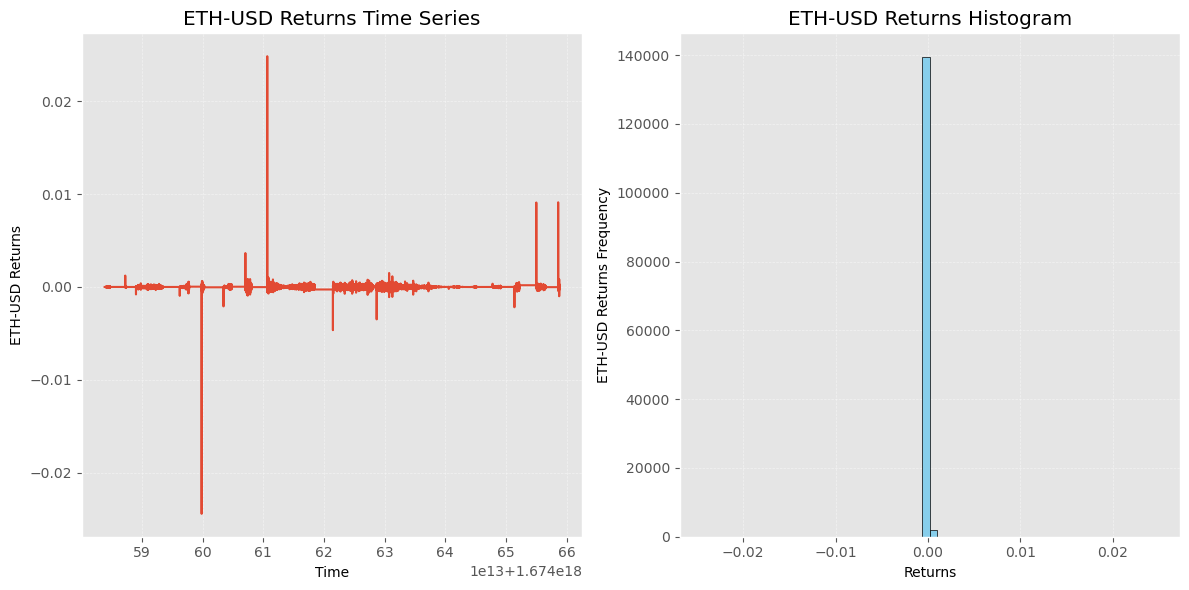

In [436]:
PlotDynamics.plot_returns_ts_hist(
    frtf_test_trades_eth_usd_df['PnL'].pct_change(),
    'ETH-USD',
    bins=60,
    use_steps_post=True
)

In [437]:
Compute.performance_statistics(
    frtf_test_trades_eth_usd_df, 'PnL'
)

,Sharpe Ratio,Max Drawdown
0,0.0009,-0.0326


### Rolling Beta

In [438]:
NUM_LAG_TRADES = 60
rolling_frtf_test_trades_btc_usd_df = frtf_test_trades_btc_usd_df.copy()
rolling_frtf_test_trades_eth_btc_df = frtf_test_trades_eth_btc_df.copy()
rolling_frtf_test_trades_eth_usd_df = frtf_test_trades_eth_usd_df.copy()



In [440]:
cols_to_remove = ['forecasted_returns', 'net_signal', 'current_position', 'PnL', f'rolling_{NUM_LAG_TRADES}_cov', f'rolling_{NUM_LAG_TRADES}_var', f'rolling_{NUM_LAG_TRADES}_beta', f'rolling_{NUM_LAG_TRADES}_prediction_future_returns']
for col in cols_to_remove:
    if col in rolling_frtf_test_trades_btc_usd_df:
        rolling_frtf_test_trades_btc_usd_df = rolling_frtf_test_trades_btc_usd_df.drop(columns=[col])
    if col in rolling_frtf_test_trades_eth_btc_df:
        rolling_frtf_test_trades_eth_btc_df = rolling_frtf_test_trades_eth_btc_df.drop(columns=[col])
    if col in rolling_frtf_test_trades_eth_usd_df:
        rolling_frtf_test_trades_eth_usd_df = rolling_frtf_test_trades_eth_usd_df.drop(columns=[col])

In [459]:
rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_cov'] = rolling_frtf_test_trades_btc_usd_df[[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns', f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']].rolling(window=NUM_LAG_TRADES).cov().unstack()[(f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns', f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow')]
rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_cov'] = rolling_frtf_test_trades_eth_btc_df[[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns', f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']].rolling(window=NUM_LAG_TRADES).cov().unstack()[(f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns', f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow')]
rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_cov'] = rolling_frtf_test_trades_eth_usd_df[[f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns', f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']].rolling(window=NUM_LAG_TRADES).cov().unstack()[(f'{FORWARD_RETURN_TIME_INTERVAL}_foward_returns', f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow')]

rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_var'] = rolling_frtf_test_trades_btc_usd_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']].rolling(window=NUM_LAG_TRADES).var()
rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_var'] = rolling_frtf_test_trades_eth_btc_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']].rolling(window=NUM_LAG_TRADES).var()
rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_var'] = rolling_frtf_test_trades_eth_usd_df[[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']].rolling(window=NUM_LAG_TRADES).var()

rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_beta'] =  rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_cov'] / rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_var']
rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_beta'] =  rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_cov'] / rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_var']
rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_beta'] =  rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_cov'] / rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_var']

rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_prediction_future_returns'] = rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_beta'] * rolling_frtf_test_trades_btc_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']
rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_prediction_future_returns'] = rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_beta'] * rolling_frtf_test_trades_eth_btc_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']
rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_prediction_future_returns'] = rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_beta'] * rolling_frtf_test_trades_eth_usd_df[f'trailing_{LAGGED_TRADEFLOW_TIME}_tradeflow']

### BTC-USD Rolling Beta

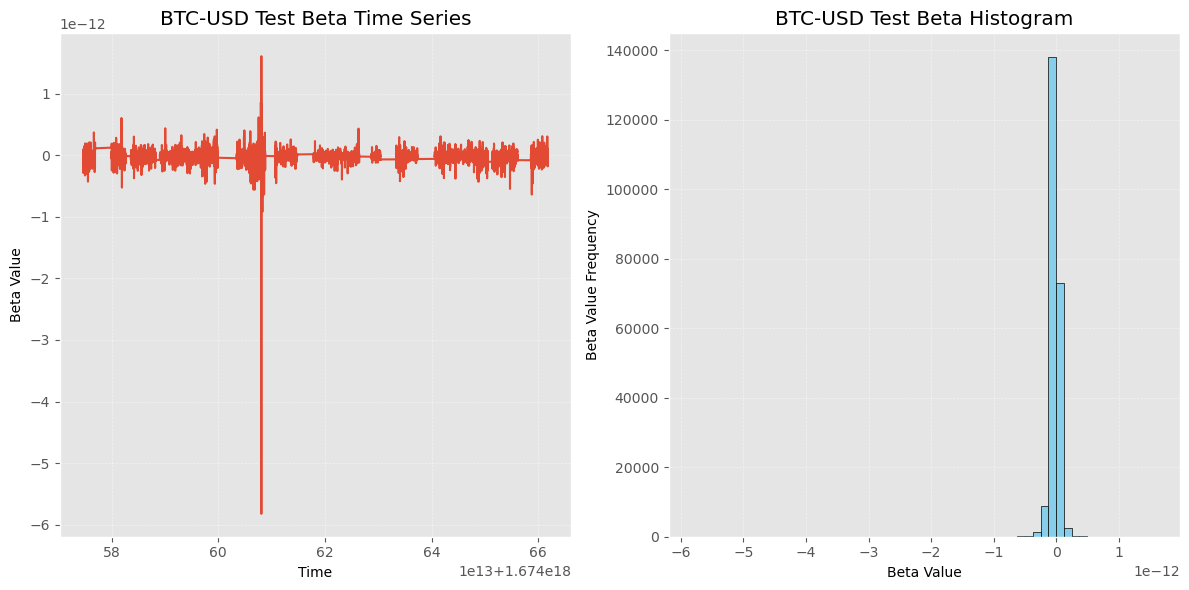

In [460]:
PlotDynamics.plot_ts_hist(
    rolling_frtf_test_trades_btc_usd_df[f'rolling_{NUM_LAG_TRADES}_beta'], 
    "BTC-USD",
    bins=60,
    title1='BTC-USD Test Beta Time Series',
    title2='BTC-USD Test Beta Histogram',
    x1label='Time',
    x2label='Beta Value',
    y1label='Beta Value',
    y2label='Beta Value Frequency',
)

In [461]:
rolling_frtf_test_trades_btc_usd_df = Compute.signal(rolling_frtf_test_trades_btc_usd_df, f'rolling_{NUM_LAG_TRADES}_prediction_future_returns', j, 10000)
rolling_frtf_test_trades_btc_usd_df['PnL'] = Compute.strategy_performance(rolling_frtf_test_trades_btc_usd_df, 'current_position', 'price')

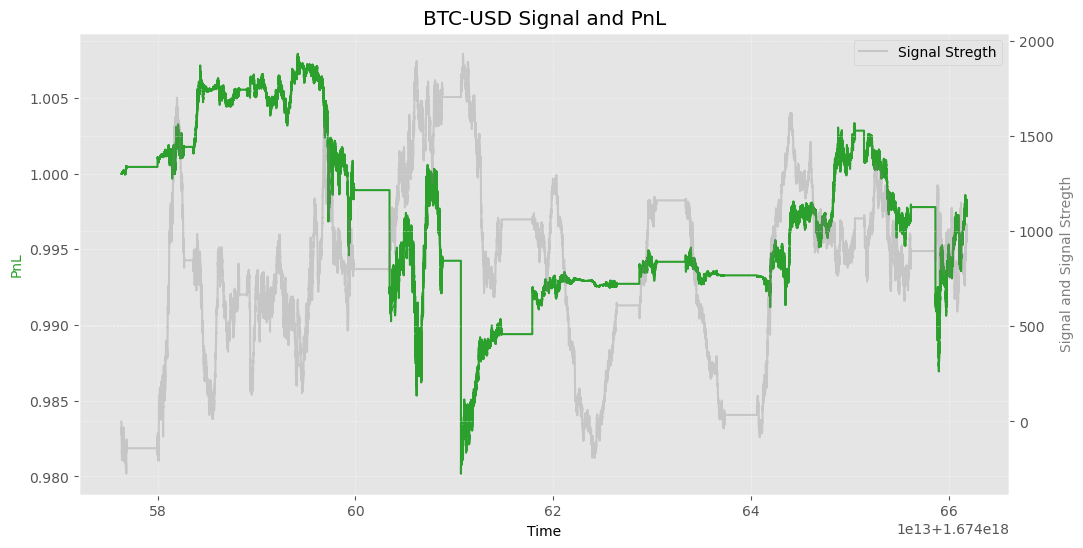

In [462]:
PlotDynamics.plot_dual_axis_timeseries(
    rolling_frtf_test_trades_btc_usd_df.index, 
    [rolling_frtf_test_trades_btc_usd_df['PnL']],
    [rolling_frtf_test_trades_btc_usd_df['current_position']], 
    y1_series_names=['PnL'],
    y2_series_names=['Signal Stregth'],
    y1label='PnL',
    y2label='Signal and Signal Stregth',
    y1color='tab:green',
    y2color='tab:grey',
    title='BTC-USD Signal and PnL',
    use_steps_post=[True, True],
    alpha=[1,0.3]
)

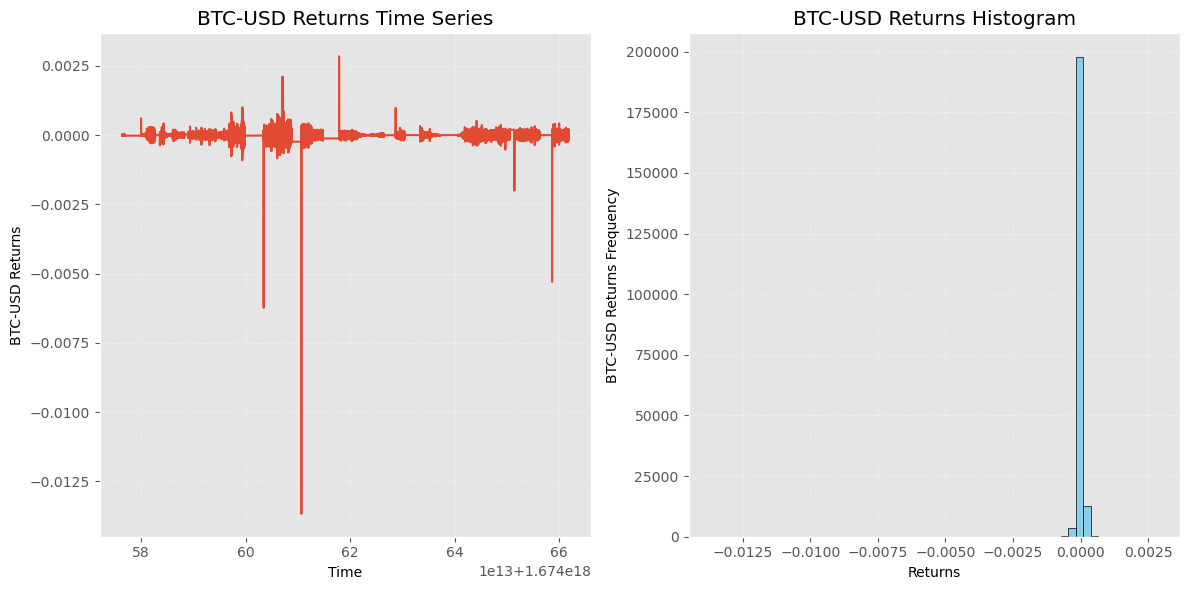

In [463]:
PlotDynamics.plot_returns_ts_hist(
    rolling_frtf_test_trades_btc_usd_df['PnL'].pct_change(),
    'BTC-USD',
    bins=60,
    use_steps_post=True
)

In [464]:
Compute.performance_statistics(
    rolling_frtf_test_trades_btc_usd_df, 'PnL'
)

,Sharpe Ratio,Max Drawdown
0,-0.0001,-0.0275


### ETH-BTC Rolling Beta

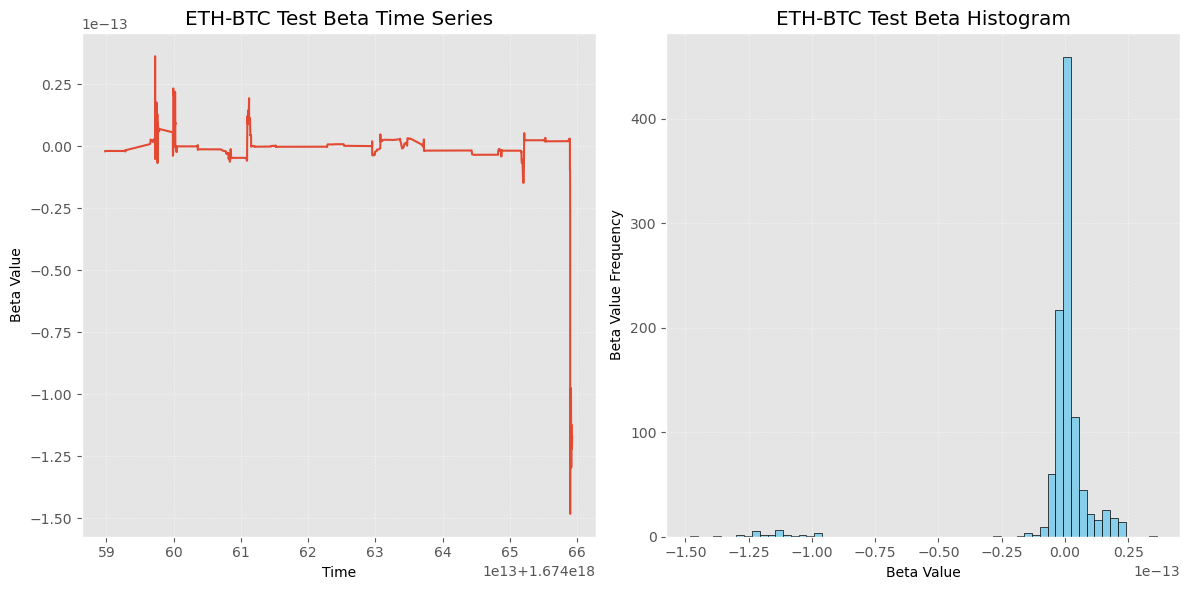

In [465]:
PlotDynamics.plot_ts_hist(
    rolling_frtf_test_trades_eth_btc_df[f'rolling_{NUM_LAG_TRADES}_beta'], 
    "ETH-BTC",
    bins=60,
    title1='ETH-BTC Test Beta Time Series',
    title2='ETH-BTC Test Beta Histogram',
    x1label='Time',
    x2label='Beta Value',
    y1label='Beta Value',
    y2label='Beta Value Frequency',
)

In [466]:

rolling_frtf_test_trades_eth_btc_df = Compute.signal(rolling_frtf_test_trades_eth_btc_df, f'rolling_{NUM_LAG_TRADES}_prediction_future_returns', j, 10)
rolling_frtf_test_trades_eth_btc_df['PnL'] = Compute.strategy_performance(rolling_frtf_test_trades_eth_btc_df, 'current_position', 'price')

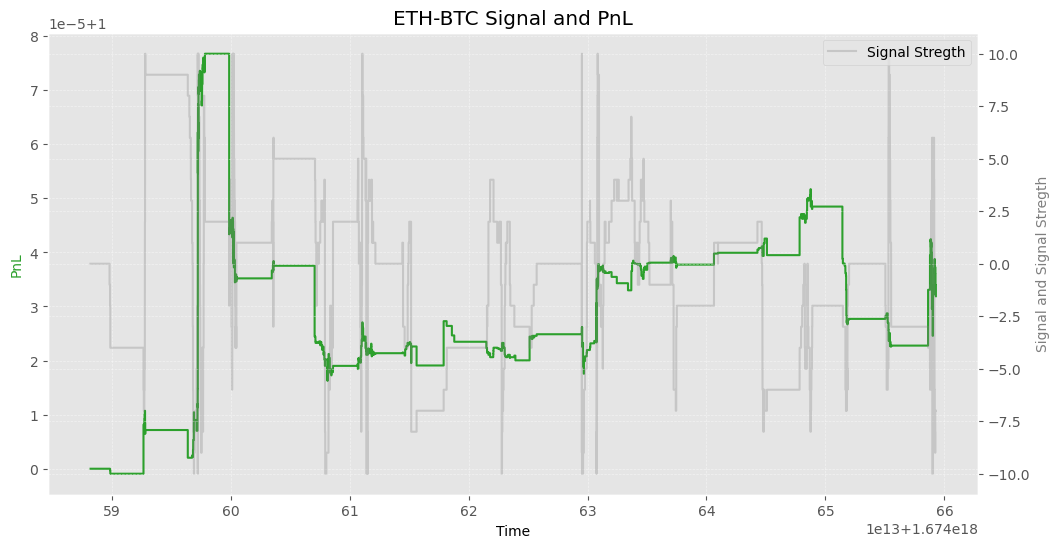

In [467]:
PlotDynamics.plot_dual_axis_timeseries(
    rolling_frtf_test_trades_eth_btc_df.index, 
    [rolling_frtf_test_trades_eth_btc_df['PnL']],
    [rolling_frtf_test_trades_eth_btc_df['current_position']], 
    y1_series_names=['PnL'],
    y2_series_names=['Signal Stregth'],
    y1label='PnL',
    y2label='Signal and Signal Stregth',
    y1color='tab:green',
    y2color='tab:grey',
    title='ETH-BTC Signal and PnL',
    use_steps_post=[True, True],
    alpha=[1,0.3]
)

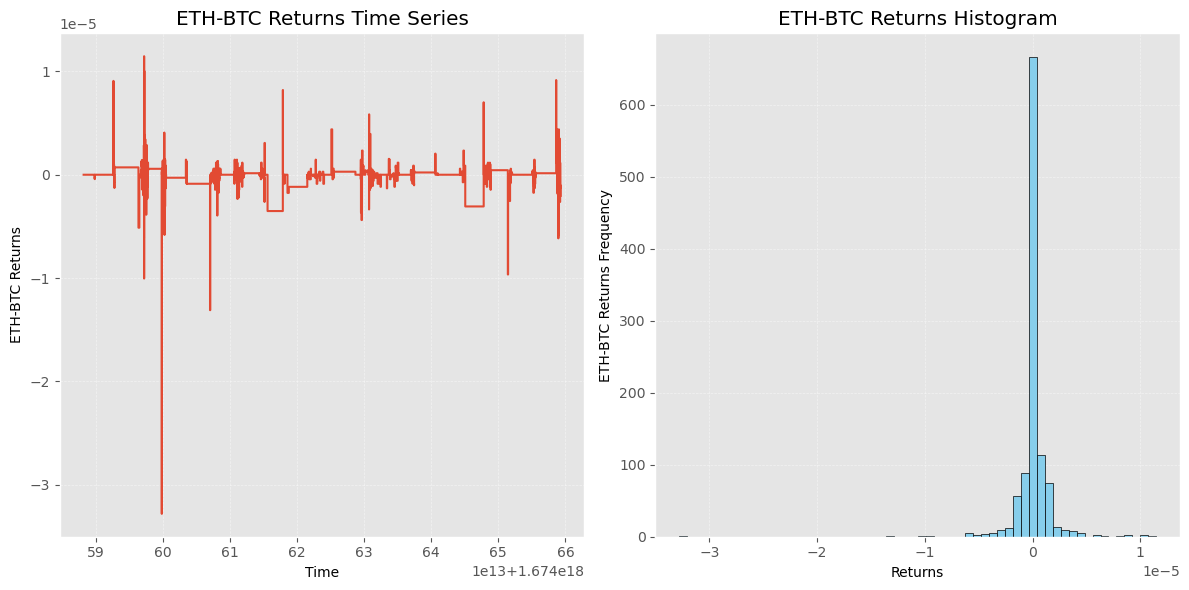

In [468]:
PlotDynamics.plot_returns_ts_hist(
    rolling_frtf_test_trades_eth_btc_df['PnL'].pct_change(),
    'ETH-BTC',
    bins=60,
    use_steps_post=True
)

In [469]:
Compute.performance_statistics(
    rolling_frtf_test_trades_eth_btc_df, 'PnL'
)

,Sharpe Ratio,Max Drawdown
0,0.0166,-0.0001


### ETH-USD Rolling Beta

In [470]:
frtf_test_trades_eth_usd_df

,price,total_volume,5000000000.0_forward_price,5000000000.0_foward_returns,directional_volume,cumsum,5000000000.0_lag_cumsum,trailing_5000000000.0_tradeflow,forecasted_returns,net_signal,current_position,PnL
timestamp_utc_nanoseconds,,,,,,,,,,,,
1674580914062753000,"1,615,263,333.3333",1250000000,"1,615,390,000.0000",0.0001,-1735715910,-3994310150,"-2,389,448,230.0000","-1,604,861,920.0000",0.0000,NaN,NaN,NaN
1674580916125332000,"1,615,390,000.0000",2236870,"1,615,580,000.0000",0.0001,2236870,-3992073280,"-2,488,410,970.0000","-1,503,662,310.0000",0.0000,NaN,NaN,NaN
1674580919250078000,"1,615,310,000.0000",1373670,"1,615,533,333.3333",0.0001,-1373670,-3993446950,"-3,994,310,150.0000","863,200.0000",-0.0000,NaN,NaN,NaN
1674580920112202000,"1,615,440,000.0000",99347230,"1,615,533,333.3333",0.0001,99347230,-3894099720,"-3,994,310,150.0000","100,210,430.0000",-0.0000,NaN,NaN,NaN
1674580920317682000,"1,615,466,666.6667",1847532430,"1,615,580,000.0000",0.0001,1847532430,-2046567290,"-3,994,310,150.0000","1,947,742,860.0000",-0.0000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1674658830318655000,"1,533,320,000.0000",4554000080,"1,533,300,000.0000",-0.0000,9174444290,-7335801219460,"-7,252,398,763,060.0000","-83,402,456,400.0000",0.0000,2.0000,-894.0000,1.0153
1674658830318708000,"1,533,335,000.0000",7617832610,"1,533,300,000.0000",-0.0000,17731624910,-7318069594550,"-7,252,398,763,060.0000","-65,670,831,490.0000",0.0000,2.0000,-892.0000,1.0153
1674658830319185000,"1,533,310,000.0000",2095786600,"1,533,300,000.0000",-0.0000,2095786600,-7315973807950,"-7,252,398,763,060.0000","-63,575,044,890.0000",0.0000,2.0000,-890.0000,1.0153


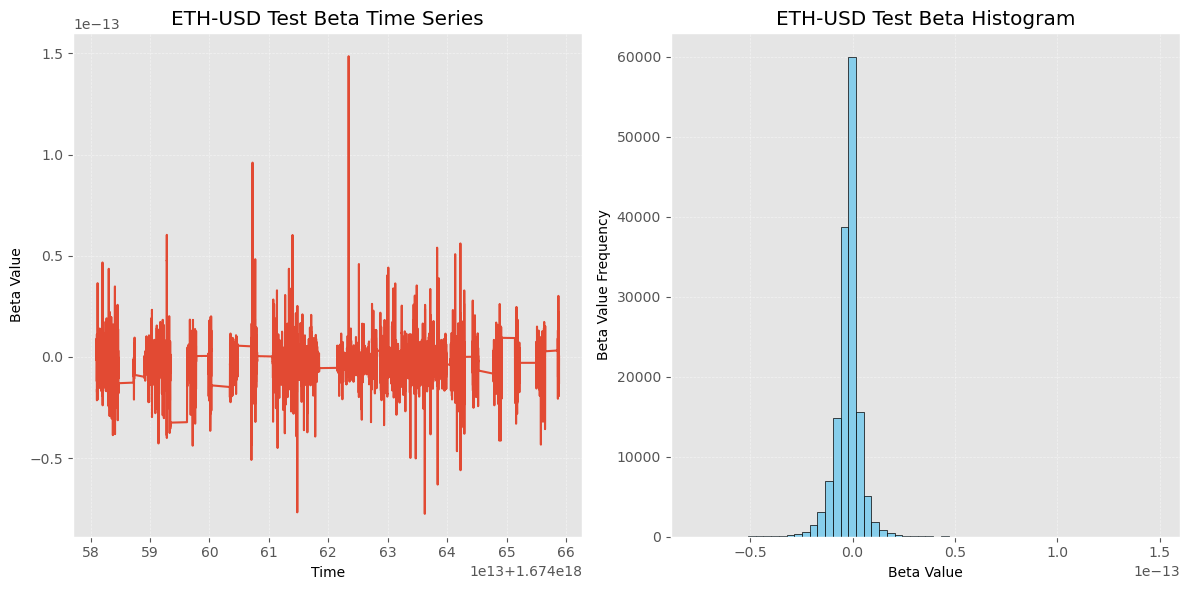

In [472]:

PlotDynamics.plot_ts_hist(
    rolling_frtf_test_trades_eth_usd_df[f'rolling_{NUM_LAG_TRADES}_beta'], 
    "ETH-USD",
    bins=60,
    title1='ETH-USD Test Beta Time Series',
    title2='ETH-USD Test Beta Histogram',
    x1label='Time',
    x2label='Beta Value',
    y1label='Beta Value',
    y2label='Beta Value Frequency',
)

In [453]:
rolling_frtf_test_trades_eth_usd_df = Compute.signal(rolling_frtf_test_trades_eth_usd_df, f'rolling_{NUM_LAG_TRADES}_prediction_future_returns', j, 10000)
rolling_frtf_test_trades_eth_usd_df['PnL'] = Compute.strategy_performance(rolling_frtf_test_trades_eth_usd_df, 'current_position', 'price')

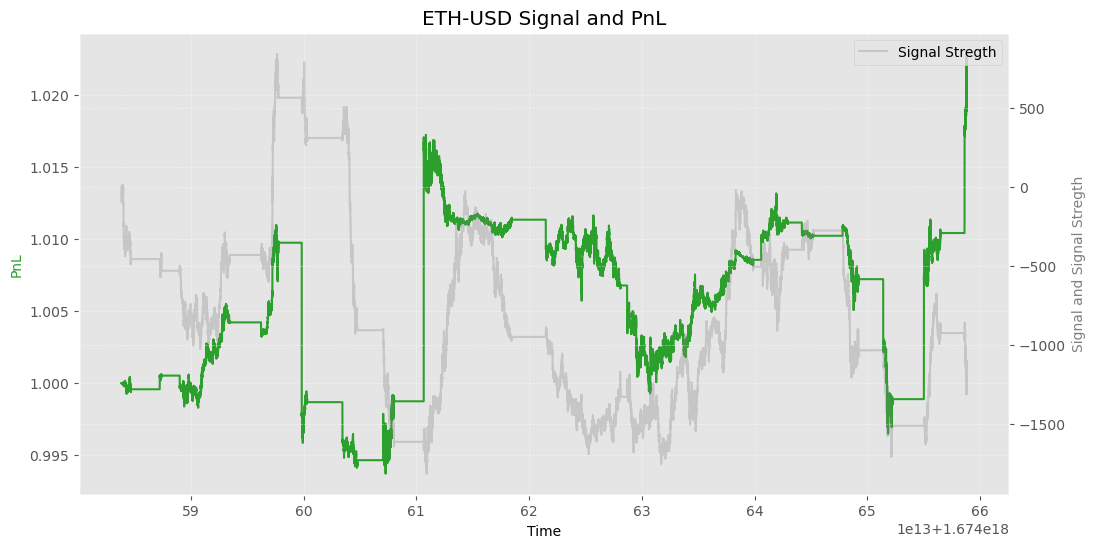

In [454]:
PlotDynamics.plot_dual_axis_timeseries(
    rolling_frtf_test_trades_eth_usd_df.index, 
    [rolling_frtf_test_trades_eth_usd_df['PnL']],
    [rolling_frtf_test_trades_eth_usd_df['current_position']], 
    y1_series_names=['PnL'],
    y2_series_names=['Signal Stregth'],
    y1label='PnL',
    y2label='Signal and Signal Stregth',
    y1color='tab:green',
    y2color='tab:grey',
    title='ETH-USD Signal and PnL',
    use_steps_post=[True, True],
    alpha=[1,0.3]
)

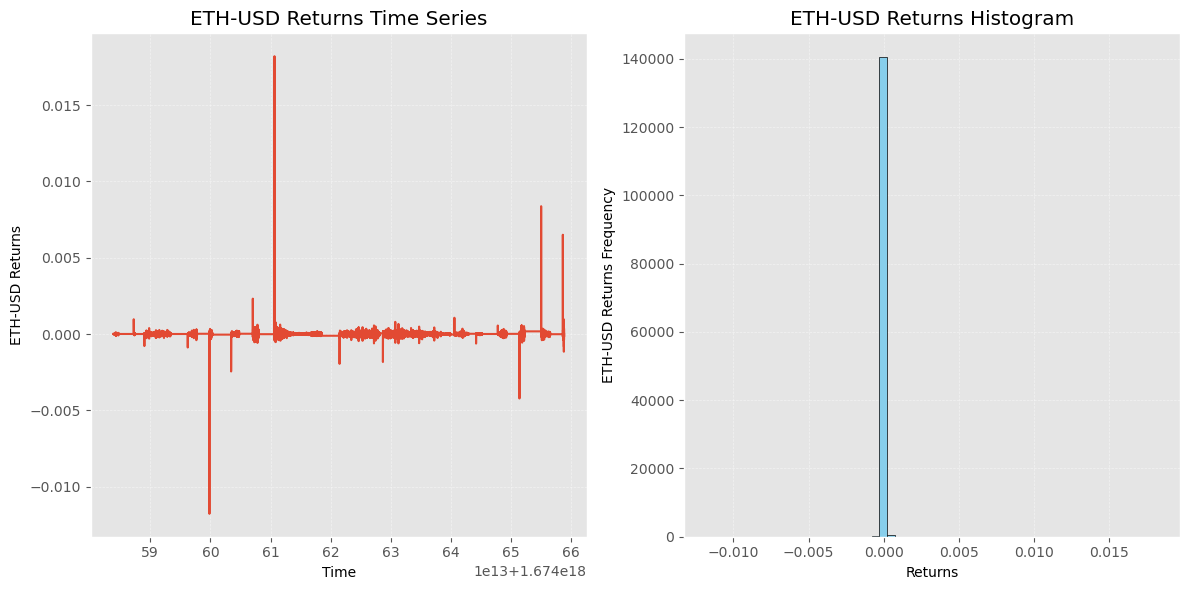

In [455]:
PlotDynamics.plot_returns_ts_hist(
    rolling_frtf_test_trades_eth_usd_df['PnL'].pct_change(),
    'ETH-USD',
    bins=60,
    use_steps_post=True
)

In [456]:
Compute.performance_statistics(
    rolling_frtf_test_trades_eth_usd_df, 'PnL'
)

,Sharpe Ratio,Max Drawdown
0,0.0019,-0.0204


## V.